<a href="https://colab.research.google.com/github/sepehr21ar/Deep_Learning_Project/blob/main/malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from  tensorflow.keras import layers, metrics, losses, optimizers
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [2]:
data_set , data_set_info = tfds.load("malaria"  , with_info=True, split=['train[:80%]', 'train[80%:90%]','train[90%:]'])

In [3]:
print(len(data_set[0]))
print(len(data_set[1]))
print(len(data_set[2]))


22046
2756
2756


In [4]:
train = (data_set[0])
val =(data_set[1])
test = (data_set[2])



In [5]:
def get_label_str (lable):
    if lable == 0:
        return 'Parasitized'
    else:
        return 'Normal'

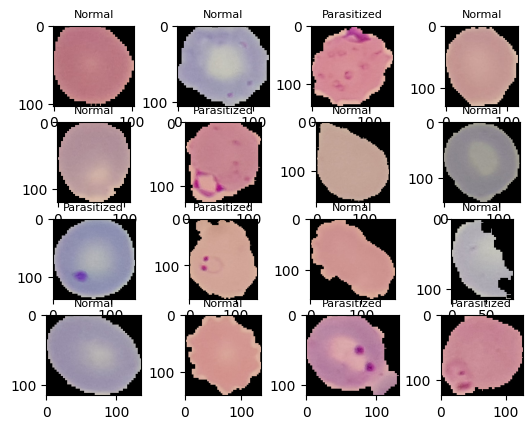

In [6]:
for i , sample in enumerate(data_set[0].take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.title(get_label_str(sample['label'].numpy()), size=8)
    plt.imshow(sample['image'])

In [7]:
IM_SIZA = 224
def resize_rescale(inputs):
    return tf.image.resize(inputs['image'] ,(IM_SIZA,IM_SIZA))/255 , inputs['label']

In [8]:
train_dataset = train.map(resize_rescale)

In [9]:
val_dataset = val.map(resize_rescale)

In [10]:
test_dataset = test.map(resize_rescale)

In [11]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [12]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
BATCH_SIZE = 32
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(IM_SIZA, IM_SIZA, 3)),
    layers.Conv2D(filters=6, kernel_size=5, strides = 1 ,padding ='valid', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    layers.Conv2D(16, 5, 1 ,padding ='valid', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    layers.Flatten(),
    layers.Dense(100, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='relu'),
    layers.BatchNormalization(),

    layers.Dense(1, activation='sigmoid'),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 220, 220, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 106, 106, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

In [16]:
model.compile(optimizer=optimizers.Adam(learning_rate= 0.003), loss=losses.binary_crossentropy, metrics=["acc"] )


In [20]:
history = model.fit(train_dataset ,validation_data = val_dataset, epochs=15, verbose=1  )

Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - acc: 0.7282 - loss: 0.5289 - val_acc: 0.5671 - val_loss: 1.7507
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - acc: 0.9316 - loss: 0.1953 - val_acc: 0.9202 - val_loss: 0.2387
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - acc: 0.9481 - loss: 0.1526 - val_acc: 0.7413 - val_loss: 0.9608
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - acc: 0.9540 - loss: 0.1354 - val_acc: 0.9380 - val_loss: 0.1862
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - acc: 0.9504 - loss: 0.1423 - val_acc: 0.9278 - val_loss: 0.2382
Epoch 6/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - acc: 0.9625 - loss: 0.1116 - val_acc: 0.8726 - val_loss: 0.7101
Epoch 7/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - acc: 0.9552 - loss: 0.1307 - val_acc: 0.9358 - val_loss: 0.2279
Epoch 8/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - acc: 0.9677 - loss: 0.0956 - val_acc: 0.9351 - val_loss: 0.2659
Epoch 9/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 

In [21]:
history.history

{'acc': [0.8210105895996094,
  0.934001624584198,
  0.944933295249939,
  0.9520094394683838,
  0.9537330865859985,
  0.957316517829895,
  0.9568629264831543,
  0.9681574702262878,
  0.9741449952125549,
  0.9781365990638733,
  0.9861199259757996,
  0.9865735173225403,
  0.990293025970459,
  0.990293025970459,
  0.9932414293289185],
 'loss': [0.38961485028266907,
  0.18742990493774414,
  0.15937833487987518,
  0.1394461989402771,
  0.13370470702648163,
  0.1240023598074913,
  0.1251879185438156,
  0.09465199708938599,
  0.07717785239219666,
  0.06313221901655197,
  0.043445199728012085,
  0.041107118129730225,
  0.0277719646692276,
  0.02611898072063923,
  0.020230602473020554],
 'val_acc': [0.5671262741088867,
  0.9201741814613342,
  0.7412917017936707,
  0.937953531742096,
  0.9277939200401306,
  0.8726415038108826,
  0.9357764720916748,
  0.9350507855415344,
  0.9365021586418152,
  0.9328737258911133,
  0.9317851662635803,
  0.9252539873123169,
  0.9408563375473022,
  0.94375908374786

In [22]:
history.epoch

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

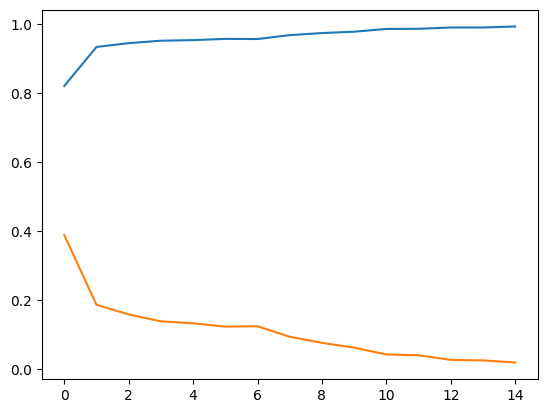

In [23]:
plt.plot(history.epoch, history.history['acc'])
plt.plot(history.epoch ,history.history['loss'])

In [24]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [25]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [26]:
test_dataset

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [27]:
test_dataset = test_dataset.batch(1)
model.evaluate(test_dataset)

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - acc: 0.9479 - loss: 0.2705


[0.2695644795894623, 0.9441218972206116]

In [28]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [29]:
model.predict(test_dataset)

2756/2756 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


array([[9.9988127e-01],
       [9.9999177e-01],
       [6.5180643e-06],
       ...,
       [9.9998760e-01],
       [9.9975353e-01],
       [7.3252676e-07]], dtype=float32)

In [30]:
def parasite_or_not(x):
  if x  < 0.5 :
    return 'Parasitized'
  else:
    return 'Normal'

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


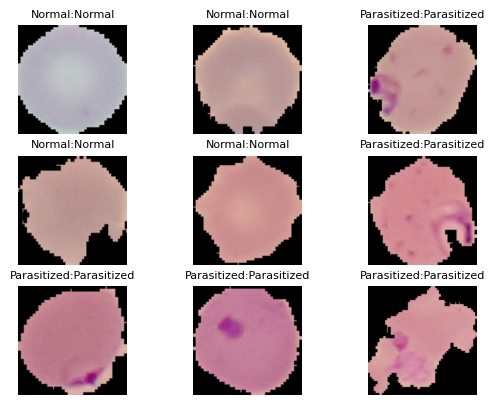

In [31]:
for i,(image,label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy())) + ":" + str(parasite_or_not(model.predict(image)[0][0])), size=8)
    plt.axis('off')